In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from scipy.stats import expon
from utils import *


In [3]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    good_dict = {}

    for key in keys:

        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        # timeLimit = mergedConfigs["sim-time-limit"]

        
        # assert timeLimit.endswith('s'), "Time limit format is incorrect"
        # timeLimit = timeLimit[:-1]  # Remove the 's' at the end

        good_dict[measurement]={}
        good_dict[measurement]['measurement']=measurement
        good_dict[measurement]['parameters']=dict(item.split("=") for item in measurement.split(", "))
        good_dict[measurement]['param']={a['name']: a['value'] for a in data[key]['parameters']}
        good_dict[measurement]['scalars']={a['name']: a['value'] for a in data[key]['scalars']}
        good_dict[measurement]['repetition']=int(repetition)
        # good_dict[measurement]['timeLimit']=int(timeLimit)
        good_dict[measurement]['modules']={}

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in good_dict[measurement]['modules']:
                good_dict[measurement]['modules'][module] = {}

            good_dict[measurement]['modules'][module][name] = {}
            good_dict[measurement]['modules'][module][name]["times"] = a["time"][:100000]
            good_dict[measurement]['modules'][module][name]["values"] = a["value"][:100000]





    return good_dict


good_dict = importData("../multicore_sched/simulations/test.json")

In [4]:
#print keys of good_dict one under another
for key in good_dict.keys():
    print(key)

$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="uniform", $durationType="uniform", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="uniform", $durationType="uniform", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="uniform", $durationType="uniform", $isFCFS=true
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=false
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="uniform", $durationType="uniform", $isFCFS=true
$pCpuBound=0.1, $rho=0.9, $meanProcessDuration=100ms

In [5]:
filter={
    "$pCpuBound"                : None,
    "$rho"                      : None,
    "$meanProcessDuration"       : '100ms',
    "$numCpus"                  : None,
    "$generationType"           : '"exponential"',
    "$durationType"             : '"exponential"',
    "$isFCFS"                   : 'true'
}

In [6]:
rhoSmall='0.5'
rhoBig='0.9'

In [7]:
rhoStrings=[f"ρ = {rhoSmall}",f"ρ = {rhoBig}"]
colors1=['#1F77B4','#FF7F0E']
colors2=['#FF00FF','#FF0000']

In [8]:
filtered_dict={}
filtered_dict_rho={}
filtered_array_rho=[]


for key, value in good_dict.items():
    key_dict = dict(item.split("=") for item in key.split(", "))
    match = True
    for f_key, f_value in filter.items():
        if f_value is None:
            continue
        if key_dict.get(f_key) != f_value:
            break
    else:
        filtered_dict[key] = value

        parametersNoRho = key_dict.copy()
        rhoPos= rhoBig == parametersNoRho["$rho"]
        parametersNoRho.pop("$rho", None)
        parametersNoRhoString=str(parametersNoRho)

        if parametersNoRhoString not in filtered_dict_rho:
            filtered_dict_rho[parametersNoRhoString]=[{},{}]
        
        filtered_dict_rho[parametersNoRhoString][rhoPos] = value.copy()

#convert filtered_dict_rho to array
for key, value in filtered_dict_rho.items():
    filtered_array_rho.append(value)

# print(filtered_dict.keys())
for key in filtered_dict.keys():
    print(key)

$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.9, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.9, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.5, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.5, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.9, $meanProcessDuration=100ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.9, $meanProcessDuration=100ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.5

In [9]:
statistic='waitedReadyTime:vector'

In [10]:
testToUse=list(filtered_dict.keys())[0]
values = filtered_dict[testToUse]['modules']["Computer.scheduler"][statistic]["values"]

In [11]:
def getMeasurement(axs,measurement):
    x=0
    y=0
    if "$numCpus=12" in measurement:
        x+=1
    if "$pCpuBound=0.9" in measurement:
        y=1

    # Format measurent = "$pCpuBound=0.1, $meanGenerationTime=30ms, $rho=0.4, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false"
    # to pCpuBound=0.1, numCpus=4
    parts = measurement.split(", ")

    pCpuBound = next(part for part in parts if "pCpuBound" in part)[1:]
    numCpus = next(part for part in parts if "numCpus" in part)[1:]

    measurementString = f"{pCpuBound}, {numCpus}"
    
    rhoVal = next(part for part in parts if "rho" in part).split("=")[1]

    return axs[x][y],measurementString

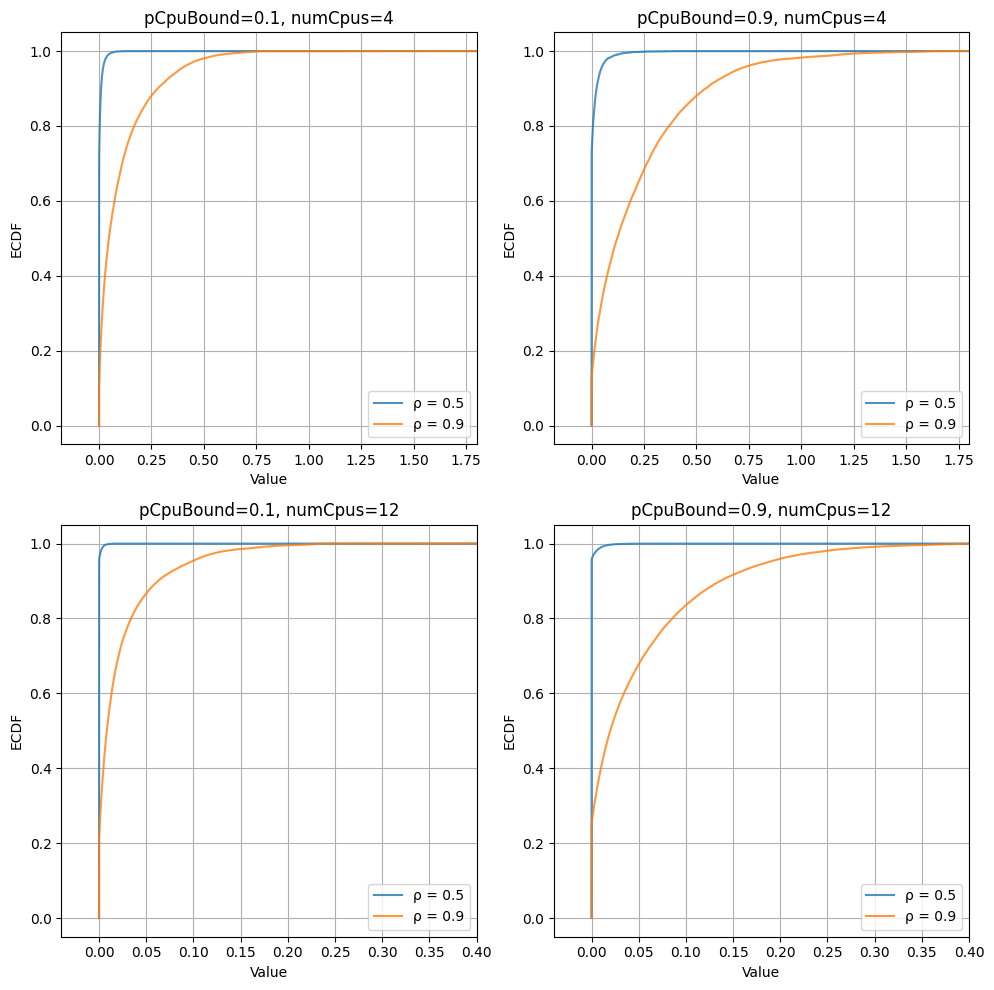

In [12]:
from statsmodels.distributions.empirical_distribution import ECDF

#for each element in filtered_array plt ecdf of statistic
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

maxXDict={}

xFin={
    '4':1.8,
    '12':0.4
}

for i, element in enumerate(filtered_array_rho):

    maxX=0
    
    for rhoNum, elementRho in enumerate(element):
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
        ecdf = ECDF(values)

        # Extend ECDF to the right

        if ecdf.x[-1] > maxX:
            maxX = ecdf.x[-1]

        x=xFin[elementRho['parameters']['$numCpus']]

        x_extended = np.append(ecdf.x,x)
        y_extended = np.append(ecdf.y,1)

        ax,measurementString = getMeasurement(axs, measurement)
        ax.step(x_extended, y_extended, label=rhoStrings[rhoNum],alpha=0.8,color=colors1[rhoNum])
        # ax.set_title(f"ECDF of {measurement}")
    
    x=xFin[element[0]['parameters']['$numCpus']]

    ax.set_xlim(-0.1*x,x)

    # ax.set_ylim(0, 1)
    ax.set_xlabel('Value')
    ax.set_ylabel('ECDF')
    ax.set_title(f'{measurementString}')
    ax.legend(loc='lower right')
    ax.grid(True)
plt.tight_layout()
plt.show()

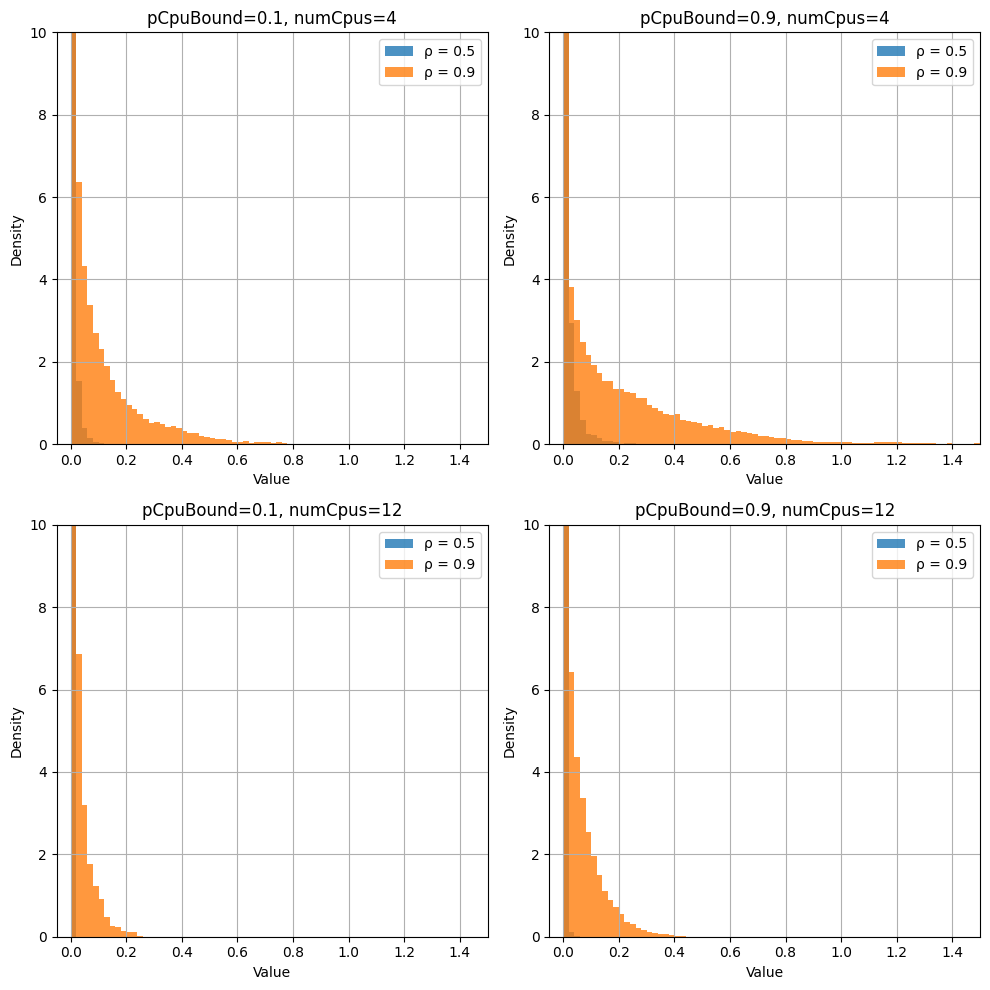

In [13]:
from scipy.stats import gamma,expon

# Assuming filtered_array, filtered_dict, and getMeasurement are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array_rho):

    for rhoNum, elementRho in enumerate(element):

        values = elementRho["modules"]["Computer.scheduler"][statistic]["values"]

        measurement = elementRho["measurement"]

        # Fit Gamma distribution to the data
        # shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma

        # print(f"Shape: {shape}, loc: {loc}, scale: {scale}")

        # Plot histogram
        ax, measurementString = getMeasurement(axs, measurement)
        ax.hist(
            values,
            bins=100,
            range=(0, 2),
            density=True,
            alpha=0.8,
            label=f"{rhoStrings[rhoNum]}",
            color=colors1[rhoNum],
        )

        # Plot fitted Gamma distribution
        # x = np.linspace(min(values), max(values), 1000)
        # pdf = gamma.pdf(x, shape, loc=loc, scale=scale)

        # lambd = 1 / scale
        # shape = round(shape, 2)
        # lambd = round(lambd, 2)
        # scale = round(scale, 2)
        # ax.plot(
        #     x,
        #     pdf,
        #     "-",
        #     label=f"α = {shape}, θ = {scale}, λ = {lambd}",
        #     alpha=0.9,
        #     color=colors2[rhoNum],
        # )
        # ax.text(0,1-rhoNum,elementRho['param']['meanGenerationTime'])

        # print(f"{elementRho['config']}")
    # x = np.linspace(0, 10, 1000)
    # pdf = expon.pdf(x, scale=0.1)  # Mean = 0.1

    # ax.plot(
    #     x,
    #     pdf,
    #     "-",
    #     label=f"Exp. Mean = 0.1",
    #     alpha=0.9,
    #     color=colors2[0],
    # )
    

    # Set labels and title
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_xlim(-0.05, 1.5)
    ax.set_ylim(0, 10)
    ax.set_title(measurementString)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

pCpuBound=0.9, numCpus=12 ρ = 0.5
0.0 0.151004269259
pCpuBound=0.9, numCpus=12 ρ = 0.9
0.0 0.792439726124
pCpuBound=0.1, numCpus=4 ρ = 0.5
0.0 0.03223378067
pCpuBound=0.1, numCpus=4 ρ = 0.9
0.0 0.269779790948
pCpuBound=0.1, numCpus=12 ρ = 0.5
0.0 0.473578578857
pCpuBound=0.1, numCpus=12 ρ = 0.9
0.0 1.690311785312
pCpuBound=0.9, numCpus=4 ρ = 0.5
0.0 0.10477634106
pCpuBound=0.9, numCpus=4 ρ = 0.9
0.0 0.430373535457


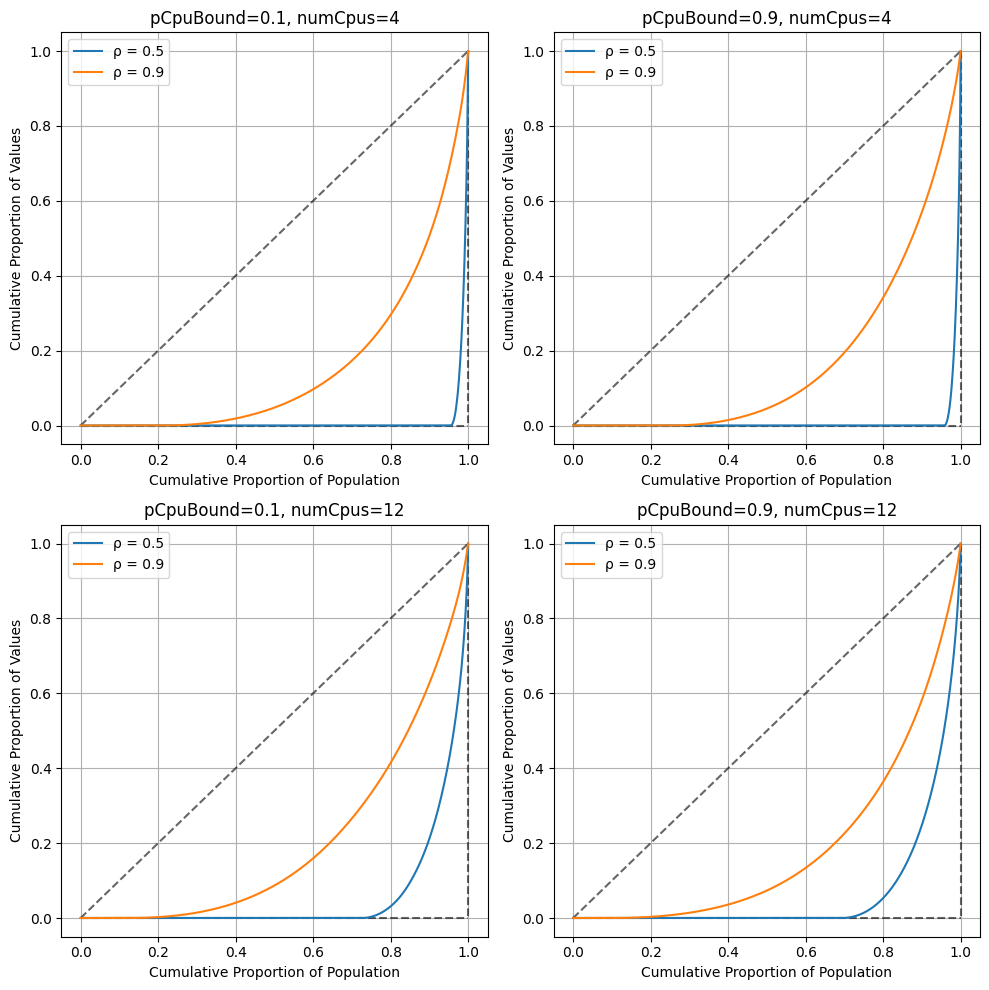

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Assuming filtered_array, filtered_dict, and getMeasurement are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

def lorenz_curve(values):
    """Compute the Lorenz curve for a given array of values."""
    values = np.sort(values)  # Sort values in ascending order
    n = len(values)
    print(values[0],values[-1])
    cumulative_values = np.cumsum(values)  # Cumulative sum of values
    cumulative_proportion = cumulative_values / cumulative_values[-1]  # Normalize to [0, 1]
    population_proportion = np.arange(1, n + 1) / n  # Cumulative proportion of population
    return population_proportion, cumulative_proportion

for i, element in enumerate(filtered_array_rho):

    ax, measurementString = getMeasurement(axs, measurement)
    
    ax.plot([0, 1], [0, 1], 'k--',alpha=0.6)
    ax.plot([1, 1], [1, 0], 'k--',alpha=0.6)
    ax.plot([0, 1], [0, 0], 'k--',alpha=0.6)

    for rhoNum, elementRho in enumerate(element):
        print(measurementString,rhoStrings[rhoNum])


        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
        
        # Compute the Lorenz curve
        population_proportion, cumulative_proportion = lorenz_curve(values)
        # Plot the Lorenz curve
        ax.plot(population_proportion, cumulative_proportion, label=rhoStrings[rhoNum], color=colors1[rhoNum])
        
    # Set labels and title
    ax.set_xlabel('Cumulative Proportion of Population')
    ax.set_ylabel('Cumulative Proportion of Values')
    ax.set_title(f'{measurementString}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

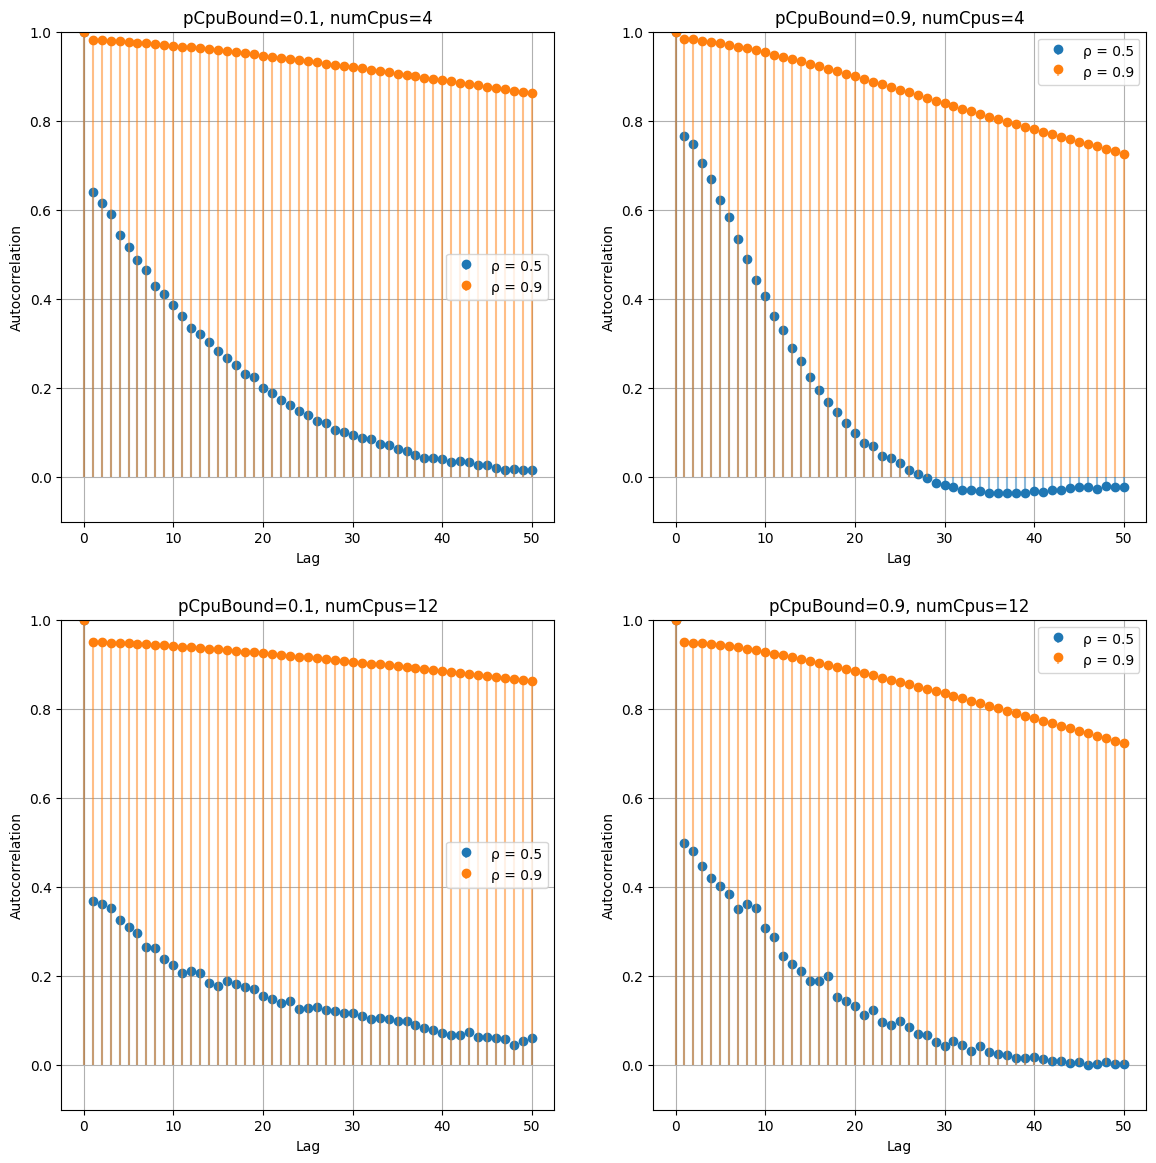

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Assuming filtered_array_rho, getMeasurement, and statistic are defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

lags = 50  # Number of lags to consider

for i, element in enumerate(filtered_array_rho):
    combValues = []
    measurement=''
    rhoVals=['','']

    for rhoNum, elementRho in enumerate(element): 
        # print(elementRho.keys())
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
    
        # Compute autocorrelation
        autocorr_values = acf(values[:len(values)//1], nlags=lags, fft=True)
    
        # print(f"Autocorrelation values for {measurement}: {autocorr_values}")

        combValues.append(autocorr_values)

        ax, measurementString = getMeasurement(axs, measurement)

    # Get the correct subplot axis
    ax, measurementString = getMeasurement(axs, measurement)
    
    # Create an x-axis for the stem plot
    x_vals = np.arange(len(autocorr_values))  # Lag indices

    top0=max(combValues[0][1:lags])
    top1=max(combValues[1][1:lags])
    top=1.2*max(top0,top1)

    for idx, autocorr_vals in (list(enumerate(combValues))):
        colorStem=f"{colors1[idx]}ff"
        colorLine=f"{colors1[idx]}80"
        ax.stem(x_vals, autocorr_vals, label=f'{rhoStrings[idx]}', linefmt=colorLine, markerfmt=colorStem, basefmt=" ")

    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    # ax.set_ylim(-top/10,top)

    if element[0]['parameters']['$numCpus']=='4':
        ax.set_ylim(-0.1,1)
    else:
        ax.set_ylim(-0.1,1)
    ax.set_title(measurementString)
    ax.legend()
    ax.grid(True)

# plt.tight_layout()
plt.show()


In [16]:
import copy
filtered_array_rho_iid=[]


for i, element in enumerate(filtered_array_rho):

    filtered_array_rho_iid.append([{},{}])

    for rhoNum, elementRho in enumerate(element):

        values = elementRho['modules']["Computer.scheduler"][statistic]["values"].copy()

        print(len(values))

        values = makeValuesIndependent(values)

        filtered_array_rho_iid[i][rhoNum] = copy.deepcopy(elementRho)

        filtered_array_rho_iid[i][rhoNum]['modules']["Computer.scheduler"][statistic]["values"]=values.copy()


61994
At the end k=6, number of samples is: 973
100000
At the end k=8, number of samples is: 379
100000
At the end k=7, number of samples is: 779
100000


KeyboardInterrupt: 

In [54]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import bootstrap


# for i, element in enumerate(filtered_array_rho_iid):

#     for rhoNum, elementRho in enumerate(element):
#         values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        
#         # Bootstrap analysis
#         data = (values,)
        
#         # Bootstrap for mean
#         res_mean = bootstrap(data, np.mean, n_resamples=999, confidence_level=0.95)
#         mean_low, mean_high = res_mean.confidence_interval
#         mean_value = np.mean(values)
        
#         # Bootstrap for std dev
#         res_dev = bootstrap(data, np.std, n_resamples=999, confidence_level=0.95)
#         dev_low, dev_high = res_dev.confidence_interval
#         std_value = np.std(values)
        
#         # Print confidence intervals
#         print(f"Confidence interval for mean: {mean_low} to {mean_high}")
#         print(f"Confidence interval for std dev: {dev_low} to {dev_high}")
        
#         # Histogram plot
#         bins = 25
#         fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        
#         ax[0].hist(res_mean.bootstrap_distribution, bins=bins)
#         ax[0].set_title('Mean')
#         ax[0].set_xlabel('Value')
#         ax[0].set_ylabel('Frequency')
        
#         ax[1].hist(res_dev.bootstrap_distribution, bins=bins)
#         ax[1].set_title('Standard Deviation')
#         ax[1].set_xlabel('Value')
#         ax[1].set_ylabel('Frequency')
        
#         plt.tight_layout()
#         plt.show()
        
#         # Store results in a table-like format
#         print("\nResults Table:")
#         print(f"{'Metric':<20} {'Mean':<15} {'95% CI Low':<15} {'95% CI High'}")
#         print(f"{'Mean':<20} {mean_value:<15.4f} {mean_low:<15.4f} {mean_high:<15.4f}")
#         print(f"{'Standard Deviation':<20} {std_value:<15.4f} {dev_low:<15.4f} {dev_high:<15.4f}\n")


In [55]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap

# Initialize a dictionary to store results
data_dict = {}

for i, element in enumerate(filtered_array_rho_iid):
    for rhoNum, elementRho in enumerate(element):
        try:
            values = np.array(elementRho['modules']["Computer.scheduler"][statistic]["values"])
            measurement = elementRho['measurement']

            # Ensure values is a NumPy array
            if values.size == 0:
                continue  # Skip empty values to avoid errors

            # Bootstrap analysis
            data = (values,)

            # Bootstrap for mean
            res_mean = bootstrap(data, np.mean, n_resamples=999, confidence_level=0.95, vectorized=True)
            mean_low, mean_high = res_mean.confidence_interval
            mean_value = np.mean(values)

            # Bootstrap for std dev
            res_dev = bootstrap(data, np.std, n_resamples=999, confidence_level=0.95, vectorized=True)
            dev_low, dev_high = res_dev.confidence_interval
            std_value = np.std(values)

            mean_value=round(mean_value*1000,1)
            mean_low=round(mean_low*1000,1)
            mean_high=round(mean_high*1000,1)
            std_value=round(std_value*1000,1)
            dev_low=round(dev_low*1000,1)
            dev_high=round(dev_high*1000,1)

            ax, measurementString = getMeasurement(axs, measurement)

            rhoString = rhoStrings[rhoNum]

            numCpus = f'numCpus = {elementRho["parameters"]["$numCpus"]}'

            pCpuBound = f'pCpuBound = {elementRho["parameters"]["$pCpuBound"]}'

            # # Organize data into dictionary format
            # if measurementString not in data_dict:
            #     data_dict[measurementString] = {}
            # if rhoString not in data_dict[measurementString]:
            #     data_dict[measurementString][rhoString] = {}

            # Organize data into dictionary format
            if numCpus not in data_dict:
                data_dict[numCpus] = {}
            if pCpuBound not in data_dict[numCpus]:
                data_dict[numCpus][pCpuBound] = {}
            if rhoString not in data_dict[numCpus][pCpuBound]:
                data_dict[numCpus][pCpuBound][rhoString] = {}

            data_dict[numCpus][pCpuBound][rhoString] = {
                ('Mean', 'Value'): mean_value,
                ('Mean', '95% CI Low'): mean_low,
                ('Mean', '95% CI High'): mean_high,
                ('Std Dev', 'Value'): std_value,
                ('Std Dev', '95% CI Low'): dev_low,
                ('Std Dev', '95% CI High'): dev_high
            }

        except KeyError as e:
            print(f"KeyError encountered: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

# Convert the nested dictionary into a properly structured DataFrame
df_results = pd.DataFrame.from_dict(
    {(numCpu,pCpuBound, rho): values for numCpu, pCpuBounds in data_dict.items() for pCpuBound, rhos in pCpuBounds.items() for rho, values in rhos.items()},
    orient='index'
)

# Set the column names as MultiIndex
df_results.columns = pd.MultiIndex.from_tuples(df_results.columns, names=['Index', ''])

# **Transpose the DataFrame to invert rows and columns**
df_results = df_results.T

# Display the DataFrame
display(df_results)


numCpus = 4                                  \
                    pCpuBound = 0.1         pCpuBound = 0.9           
                            ρ = 0.5 ρ = 0.9         ρ = 0.5 ρ = 0.9   
Index                                                                 
Mean    Value                   2.7    92.4             5.8   213.0   
        95% CI Low              2.3    81.6             4.7   186.1   
        95% CI High             3.3   103.7             8.1   242.7   
Std Dev Value                   7.8   108.9            21.5   252.7   
        95% CI Low              6.4    99.4            14.4   221.6   
        95% CI High             9.4   120.4            36.2   300.0   

                       numCpus = 12                                  
                    pCpuBound = 0.1         pCpuBound = 0.9          
                            ρ = 0.5 ρ = 0.9         ρ = 0.5 ρ = 0.9  
Index                                                                
Mean    Value                   0.1    21.2             0.3    43.0  
        95% CI Low              0.1    18.0             0.2    36.9  
        95% CI High             0.2    25.0             0.6    50.4  
Std Dev Value                   0.9    35.4             2.2    64.8  
        95% CI Low              0.6    30.8             1.3    56.6  
        95% CI High             1.3    43.0             4.2    75.3

In [56]:
latex_code = df_results.to_latex(
    float_format="%.2f",  # Format floats to 2 decimal places
    column_format="l" + "c" * len(df_results.columns),  # Left-align first column, center others
    multicolumn_format="c",  # Center-align multi-level headers
    multirow=True  # Enable multirow for hierarchical columns
)

# Print or save the LaTeX code
print(latex_code)

# Save to a file
with open("results_table.tex", "w") as f:
    f.write(latex_code)


\begin{tabular}{lcccccccc}
\toprule
 &  & \multicolumn{4}{c}{numCpus = 4} & \multicolumn{4}{c}{numCpus = 12} \\
 &  & \multicolumn{2}{c}{pCpuBound = 0.1} & \multicolumn{2}{c}{pCpuBound = 0.9} & \multicolumn{2}{c}{pCpuBound = 0.1} & \multicolumn{2}{c}{pCpuBound = 0.9} \\
 &  & ρ = 0.5 & ρ = 0.9 & ρ = 0.5 & ρ = 0.9 & ρ = 0.5 & ρ = 0.9 & ρ = 0.5 & ρ = 0.9 \\
Index &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{Mean} & Value & 2.70 & 92.40 & 5.80 & 213.00 & 0.10 & 21.20 & 0.30 & 43.00 \\
 & 95% CI Low & 2.30 & 81.60 & 4.70 & 186.10 & 0.10 & 18.00 & 0.20 & 36.90 \\
 & 95% CI High & 3.30 & 103.70 & 8.10 & 242.70 & 0.20 & 25.00 & 0.60 & 50.40 \\
\cline{1-10}
\multirow[t]{3}{*}{Std Dev} & Value & 7.80 & 108.90 & 21.50 & 252.70 & 0.90 & 35.40 & 2.20 & 64.80 \\
 & 95% CI Low & 6.40 & 99.40 & 14.40 & 221.60 & 0.60 & 30.80 & 1.30 & 56.60 \\
 & 95% CI High & 9.40 & 120.40 & 36.20 & 300.00 & 1.30 & 43.00 & 4.20 & 75.30 \\
\cline{1-10}
\bottomrule
\end{tabular}



In [57]:
import pandas as pd
import pandas as pd

def df_to_latex_custom(df):
    # Generate LaTeX table from DataFrame
    latex_code = df.to_latex(
        float_format="%.1f",  # Format floats to 1 decimal place
        column_format="llc|c|c|c|c|c|c|c",  # Column alignment as per your structure
        multicolumn_format="c",  # Center-align headers
        multirow=True  # Allow multirow formatting
    )

    # Header for manual formatting
    header_fix = r"""
\begin{table}[h]
    \centering
    \scriptsize
    \begin{tabular}{llc|c|c|c|c|c|c|c}
    \toprule
    & & \multicolumn{4}{c|}{numCpus = 4} & \multicolumn{4}{c}{numCpus = 12} \\
    & & \multicolumn{2}{c|}{pCpuBound = 0.1} & \multicolumn{2}{c|}{pCpuBound = 0.9} & \multicolumn{2}{c|}{pCpuBound = 0.1} & \multicolumn{2}{c}{pCpuBound = 0.9} \\
    & & $\rho = 0.5$ & $\rho = 0.9$ & $\rho = 0.5$ & $\rho = 0.9$ & $\rho = 0.5$ & $\rho = 0.9$ & $\rho = 0.5$ & $\rho = 0.9$ \\
    \midrule
    """

    # Footer for closing the table
    footer_fix = r"""
    \bottomrule
    \end{tabular}
    \caption{Bootstrap Results}
    \label{tab:bootstrap_results}
\end{table}
    """

    # Convert to list of lines and remove unwanted headers
    lines = latex_code.split("\n")
    
    # Remove duplicate headers generated by Pandas
    start_index = next((i for i, line in enumerate(lines) if "Metric" in line), None)
    if start_index:
        filtered_lines = lines[start_index:]  # Keep everything from "Metric" onwards
    else:
        filtered_lines = lines  # Fallback in case the header isn't found

    # Remove redundant bottom rule if it exists
    if "\\bottomrule" in filtered_lines[-1]:
        filtered_lines = filtered_lines[:-1]

    # Join all parts together
    final_latex_code = header_fix + "\n".join(filtered_lines) + footer_fix
    
    return final_latex_code

# Example Usage:
# print(df_to_latex_custom(df_results))

# Example usage:
# print(df_to_latex_custom(df_results))

latex_code=df_to_latex_custom(df_results)

with open("results_table.tex", "w") as f:
    f.write(latex_code)


In [58]:
# from scipy.stats import gamma, probplot
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming filtered_array_rho, filtered_dict, getMeasurement, rhoStrings, and colors1 are already defined

# # Create subplots
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# for i, element in enumerate(filtered_array_rho):
    
#     ax, measurementString = getMeasurement(axs, measurement)
    
#     for rhoNum, elementRho in enumerate([element[0]]):
#         values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
#         measurement = elementRho["measurement"]
        
#         # Fit Gamma distribution to the data
#         shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma
        
#         print(f"Shape: {shape}, loc: {loc}, scale: {scale}")
        
#         # Generate Q-Q plot
#         probplot(values, dist=gamma, sparams=(shape, loc, scale), plot=ax)
#         for line in ax.get_lines():
#             line.set_markersize(3)  # Set dot size
        
#     # Customize first set of dots (blue with purple)
#     ax.get_lines()[0].set_color(colors1[0])
#     ax.get_lines()[0].set_alpha(1)
#     ax.get_lines()[1].set_alpha(0.8)
#     # ax.get_lines()[0].set_markerfacecolor(colors1[1])
    
#     # Customize second set of dots (orange) and line (red)
#     # ax.get_lines()[2].set_color(colors1[1])
#     # ax.get_lines()[2].set_alpha(0.6)
#     # ax.get_lines()[3].set_alpha(0.3)

#     # ax.get_lines()[1].set_linewidth(2)
#     # Customize plot
#     ax.set_title(f'Q-Q Plot: {measurementString}')
#     ax.grid(True)
#     ax.legend([f'{rhoStrings[rhoNum]}'], loc='best')

# plt.tight_layout()
# plt.show()


FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'gamma' requires that 0 < (x - loc)/scale  < inf for each x in `data`.

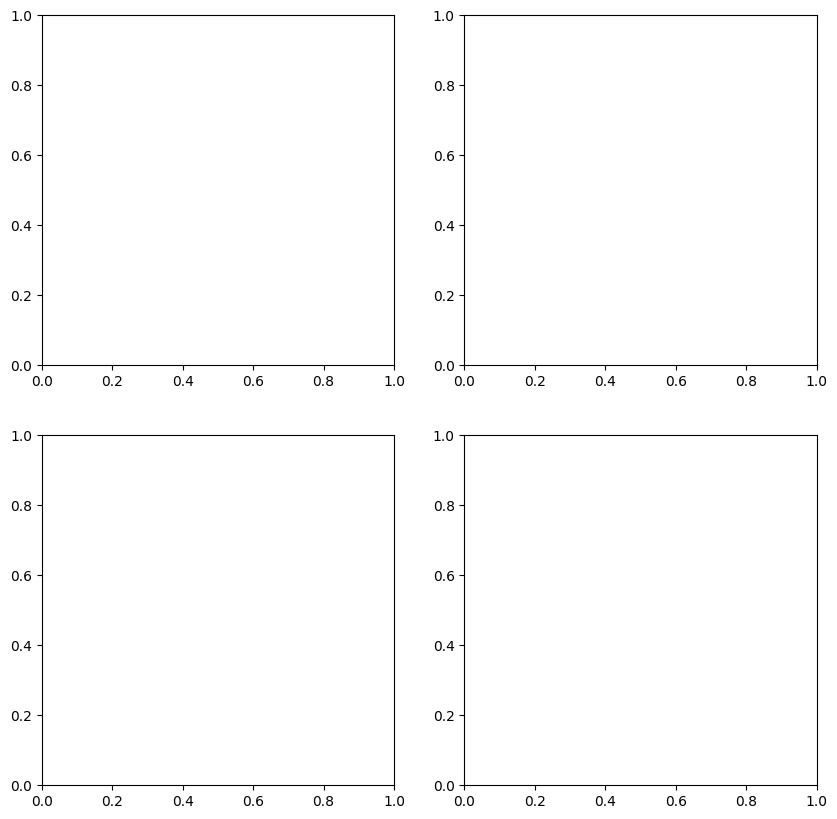

In [59]:
from scipy.stats import gamma, probplot
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_array_rho, filtered_dict, getMeasurement, rhoStrings, and colors1 are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array_rho):
    
    ax, measurementString = getMeasurement(axs, measurement)
    
    for rhoNum, elementRho in enumerate(element):
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
        
        # Fit Gamma distribution to the data
        shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma
        
        print(f"Shape: {shape}, loc: {loc}, scale: {scale}")
        
        # Generate Q-Q plot
        probplot(values, dist=gamma, sparams=(shape, loc, scale), plot=ax)
        for line in ax.get_lines():
            line.set_markersize(3)  # Set dot size
        
    # Customize first set of dots (blue with purple)
    ax.get_lines()[0].set_color(colors1[0])
    ax.get_lines()[0].set_alpha(0.6)
    ax.get_lines()[1].set_alpha(0.3)
    # ax.get_lines()[0].set_markerfacecolor(colors1[1])
    
    # Customize second set of dots (orange) and line (red)
    ax.get_lines()[2].set_color(colors1[1])
    ax.get_lines()[2].set_alpha(0.6)
    ax.get_lines()[3].set_alpha(0.3)

    # ax.get_lines()[1].set_linewidth(2)
    # Customize plot
    ax.set_title(f'Q-Q Plot: {measurementString}')
    ax.grid(True)
    ax.legend([f'{rhoStrings[rhoNum]}'], loc='best')

plt.tight_layout()
plt.show()


Shape: 1.0525172585468054, loc: 0, scale: 0.09789010378086917
Shape: 0.996764988644067, loc: 0, scale: 0.10016461718827756
Shape: 1.0670941390130226, loc: 0, scale: 0.10113522670473309
Shape: 1.0074937311112566, loc: 0, scale: 0.09933706905700655


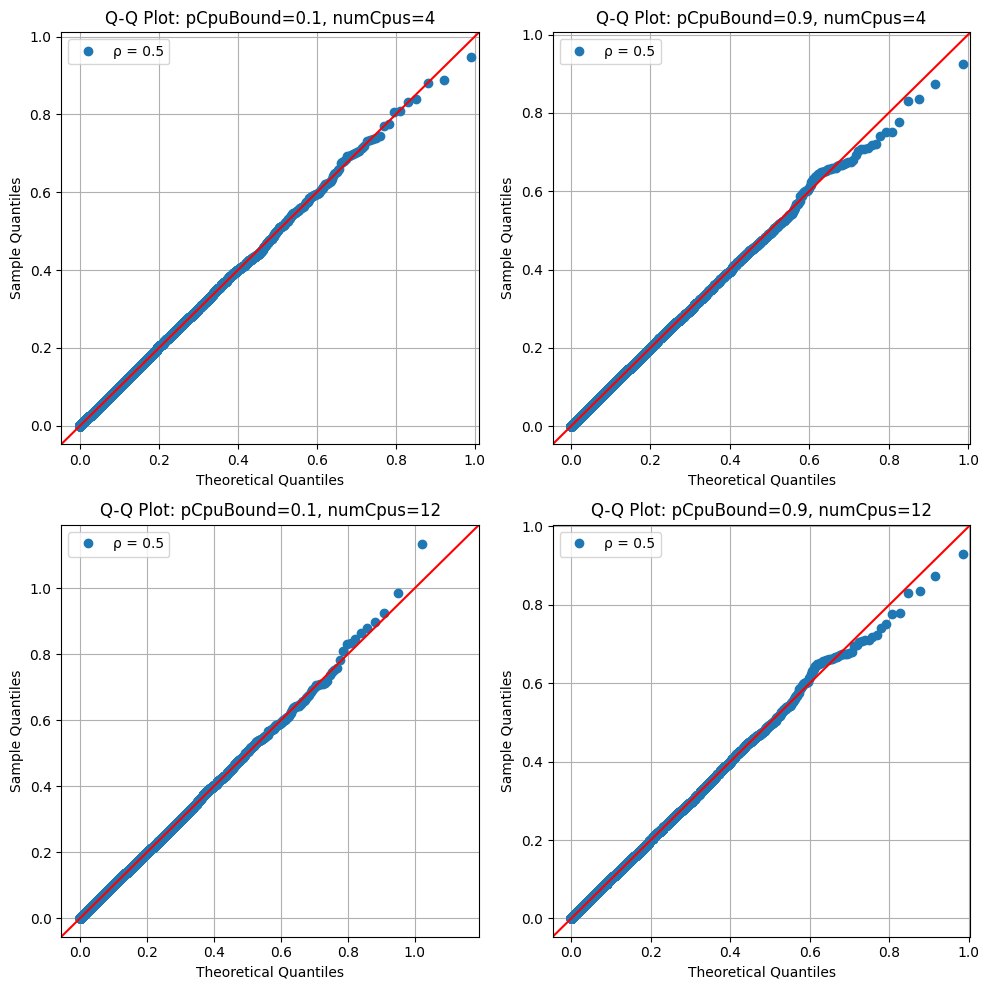

In [149]:
import statsmodels.api as sm
from scipy.stats import gamma
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_array_rho, filtered_dict, getMeasurement, rhoStrings, and colors1 are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array_rho):
    
    ax, measurementString = getMeasurement(axs, measurement)
    rhoNum=0
    elementRho = element[rhoNum]
    values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
    measurement = elementRho["measurement"]
        
    # Fit Gamma distribution to the data
    shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma
        
    print(f"Shape: {shape}, loc: {loc}, scale: {scale}")
        
    # Generate Q-Q plot using statsmodels
    sm.qqplot(np.array(values), dist=gamma, distargs=(shape,),loc=loc,scale=scale, line='45', ax=ax)
        
    
    ax.get_lines()[0].set_markerfacecolor(colors1[0])
    ax.get_lines()[0].set_markeredgecolor(colors1[0])

    # Customize plot
    ax.set_title(f'Q-Q Plot: {measurementString}')
    ax.grid(True)
    ax.legend([f'{rhoStrings[rhoNum]}'], loc='best')

plt.tight_layout()
plt.show()

Shape: 1.4577834893363755, loc: 0, scale: 0.12209336681819463
Shape: 1.2936254385548158, loc: 0, scale: 0.10362343659872844
Shape: 1.2390878647034584, loc: 0, scale: 0.2868730053045887
Shape: 1.3307966018153914, loc: 0, scale: 0.10852102840159432


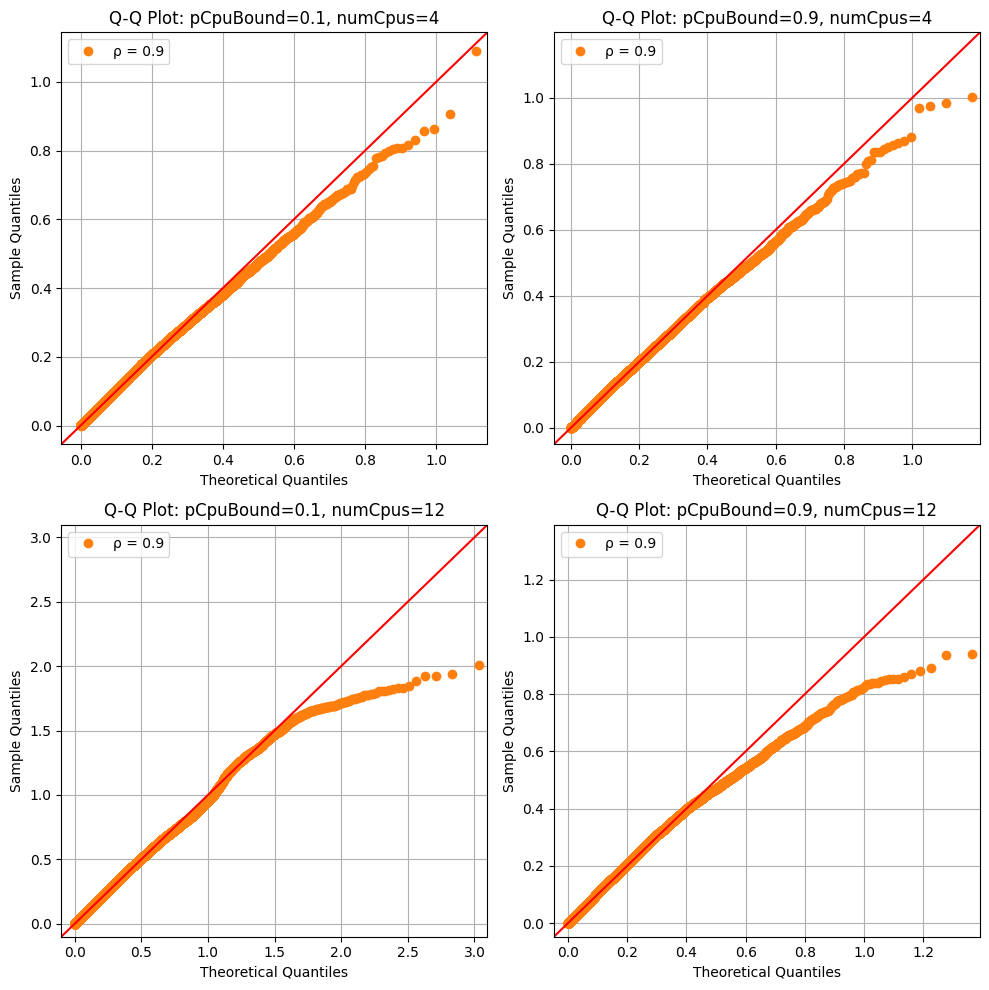

In [150]:
import statsmodels.api as sm
from scipy.stats import gamma
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_array_rho, filtered_dict, getMeasurement, rhoStrings, and colors1 are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array_rho):
    
    ax, measurementString = getMeasurement(axs, measurement)
    rhoNum=1
    elementRho = element[rhoNum]
    values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
    measurement = elementRho["measurement"]
        
    # Fit Gamma distribution to the data
    shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma
        
    print(f"Shape: {shape}, loc: {loc}, scale: {scale}")
        
    # Generate Q-Q plot using statsmodels
    sm.qqplot(np.array(values), dist=gamma, distargs=(shape,),loc=loc,scale=scale, line='45', ax=ax)
    
    ax.get_lines()[0].set_markerfacecolor(colors1[1])
    ax.get_lines()[0].set_markeredgecolor(colors1[1])
    # Customize plot
    ax.set_title(f'Q-Q Plot: {measurementString}')
    ax.grid(True)
    ax.legend([f'{rhoStrings[rhoNum]}'], loc='best')

plt.tight_layout()
plt.show()

In [151]:
# testToUse="""$pCpuBound=0.9, $rho=0.8, $meanProcessDuration=500ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true"""


In [152]:
# values = filtered_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

# p=1/2**0

# new_values=[]

# for value in values:
#     rand=np.random.uniform()
#     if rand<p:
#         new_values.append(value)

# values=new_values


# avg, std = avg_and_std(values)

# # Calculate autocorrelation
# autocorr_values = autocorrelation(values)

# stop=100
# lags=range(0,stop)

# plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
# plt.title(f"Sample Autocorrelation")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
# # plt.ylim(top=0.12)


# # Add horizontal lines at ±1.96/sqrt(n)
# n = len(values)  # Sample size
# confidence_interval = 1.96 / np.sqrt(n)
# plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
# plt.axhline(y=-confidence_interval, color='r', linestyle='--')

# plt.grid(True)
# plt.legend()
# plt.show()


# # #Ljung–Box test

# # h=30

# # Q=0
# # n=len(values)

# # for i in range(1,h):
# #     Q+=n*(n+2)*(autocorr_values[i]**2)/(n-i)

# # print(f"h: {h}, Q: {Q}")

# # # Calculate number of values outside confidence interval

# # outside=0


# # test_values=autocorr_values[1:]

# # for value in test_values:
# #     if value > confidence_interval or value < -confidence_interval:
# #         outside+=1

# # print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# # # Calculate number of values outside confidence interval near

# # outside=0
# # stop=100

# # test_values=autocorr_values[1:stop]

# # for value in test_values:
# #     if value > confidence_interval or value < -confidence_interval:
# #         outside+=1

# # print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# # print(f"Now the number of samples is: {len(values)}")

In [153]:
# # testToUse=names[1]

# values = good_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

# values= makeValuesIndependent(values)

# avg, std = avg_and_std(values)

# # Calculate autocorrelation
# autocorr_values = autocorrelation(values)

# stop=60
# lags=range(0,stop)

# plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
# plt.title(f"Sample Autocorrelation")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")
# plt.ylim(top=max(autocorr_values[1:]*1.2))


# # plt.ylim(top=max(autocorr_values[1:]*1.2))
# # plt.ylim(top=0.12)


# # Add horizontal lines at ±1.96/sqrt(n)
# n = len(values)  # Sample size
# assert n > 500
# confidence_interval = 1.96 / np.sqrt(n)
# plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
# plt.axhline(y=-confidence_interval, color='r', linestyle='--')

# plt.grid(True)
# plt.legend()
# plt.show()


In [154]:
# from scipy.stats import expon

# #histogram of values
# bins=100
# plt.hist(values,bins=bins,density=True)

# #plot also a exponential curve
# # Fit an exponential distribution to the data
# loc, scale = expon.fit(values,floc=0)
# print(f"Fitted with mean {scale}")

# # Generate the x values for the exponential curve
# x = np.linspace(min(values), max(values), bins)

# # Plot the exponential curve
# # plt.plot(x, 2*len(values)/bins*expon.pdf(x, loc, scale), 'r-', lw=2, label='Exponential fit', alpha=0.8)
# plt.plot(x, expon.pdf(x, 0, scale), 'r-', lw=2, label='Exponential fit', alpha=0.6)
# plt.legend()
# # plt.xlim(-0.05,1.5)
# plt.show()


In [155]:
# #qq plot
# import scipy.stats as stats

# # Generate a QQ plot
# # fig, ax = plt.subplots()
# res=stats.probplot(values, dist="expon", sparams=(loc, scale))

In [156]:
# #plot 1 quantile for each 10 available

# step=1
# # step=len(values)//20

# # Generate a QQ plot with step
# fig, ax = plt.subplots()
# res = stats.probplot(values[::step], dist="expon", sparams=(loc, scale), plot=ax)
# ax.grid(True)
# plt.show()

In [157]:
# from scipy.stats import bootstrap

In [158]:
# def stdDev(values):
#     return np.std(values)
# def mean(values):
#     return np.mean(values)

In [159]:
# data = (values,)  # samples must be in a sequence

# # Bootstrap for mean
# res_mean = bootstrap(data, mean, n_resamples=999, confidence_level=0.95)
# low, high = res_mean.confidence_interval
# print(f"Confidence interval for mean: {low} to {high}")
# bins=25
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
# ax[0].hist(res_mean.bootstrap_distribution, bins=bins)
# ax[0].set_title('Mean')
# ax[0].set_xlabel('Standard Deviation')
# ax[0].set_ylabel('Frequency')

# # Bootstrap for std dev
# res_dev = bootstrap(data, stdDev, n_resamples=999, confidence_level=0.95)
# low, high = res_dev.confidence_interval
# print(f"Confidence interval for mean: {low} to {high}")

# ax[1].hist(res_dev.bootstrap_distribution, bins=bins)
# ax[1].set_title('Std Dev')
# ax[1].set_xlabel('Mean')
# ax[1].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()



In [160]:
# sampMean, sampStd = avg_and_std(values)

# confLef=sampMean-1.96*sampStd/np.sqrt(len(values))
# confRig=sampMean+1.96*sampStd/np.sqrt(len(values))

# print(f"Confidence interval: {confLef} to {confRig}")

In [161]:
# import numpy as np

# from scipy import stats

# import matplotlib.pyplot as plt

# nsample = 100

# rng = np.random.default_rng()